In [1]:
import os
import sys
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath("../../nnets"))
from graph import Node, Parameter, display_chain

# Read in our data, and fill missing values
data = pd.read_csv("../../data/clean_weather.csv", index_col=0)
data = data.ffill()

x = data[:10][["tmax", "tmin", "rain"]].to_numpy()
y = data[:10][["tmax_tomorrow"]].to_numpy()

In [2]:
class MatMul(Node):
    def forward(self, x, w):
        return x @ w

    def backward(self, grad):
        x, w = self.cache
        return grad @ w.T, x.T @ grad

class Add(Node):
    def forward(self, x, b):
        return x + b

    def backward(self, grad):
        return grad, grad

class Pow(Node):
    def forward(self, x, exponent):
        return x ** exponent

    def backward(self, grad):
        x, exponent = self.cache
        return grad * exponent * x ** (exponent - 1), 1

class Subtract(Node):
    def forward(self, x, y):
        return x - y

    def backward(self, grad):
        return grad, -grad

class Relu(Node):
    def forward(self, x):
        return np.maximum(x, 0)

    def backward(self, grad):
        x = self.cache[0]
        grad[x < 0] = 0
        return grad

In [3]:
w1 = np.random.rand(3, 3)
b1 = np.random.rand(1, 3)
w2 = np.random.rand(3,1)
b2 = np.random.rand(1, 1)

l1 = x @ w1 + b1
l1_activated = np.maximum(l1, 0)
l2 = l1_activated @ w2 + b2

loss = (l2 - y) ** 2
loss_grad = (l2 - y) * 2

l2_w_grad = l1_activated.T @ loss_grad
l2_b_grad = loss_grad.sum(axis=0)

l1_grad = loss_grad @ w2.T
l1_grad[l1 < 0] = 0

l1_w_grad = x.T @ l1_grad
l1_b_grad = l1_grad.sum(axis=0)

In [4]:
l1_w_grad

array([[2.59973960e+04, 2.29391714e+04, 8.81656124e+03],
       [2.00402621e+04, 1.76828097e+04, 6.79630366e+03],
       [3.62551403e+01, 3.19902376e+01, 1.22952954e+01]])

In [5]:
X = Parameter(x, desc="X", needs_grad=False)
Y = Parameter(y, desc="y", needs_grad=False)

w1_param = Parameter(w1, desc="W1")
b1_param = Parameter(b1, desc="b1")

matmul1 = MatMul(X, w1_param, out="X @ W1")
add1 = Add(matmul1, b1_param, out="Z1")

layer1 = Relu(add1, out="A1")

w2_param = Parameter(w2, desc="W2")
b2_param = Parameter(b2, desc="b2")
matmul2 = MatMul(layer1, w2_param, out="Z1 @ W2")
add2 = Add(matmul2, b2_param, out="Z2")

sub = Subtract(add2, Y, out="p - y")
square = Parameter(2, desc="2", needs_grad=False)
pow = Pow(sub, square, out="L")
auto_loss = pow.apply_fwd()

In [6]:
np.allclose(loss, auto_loss)

True

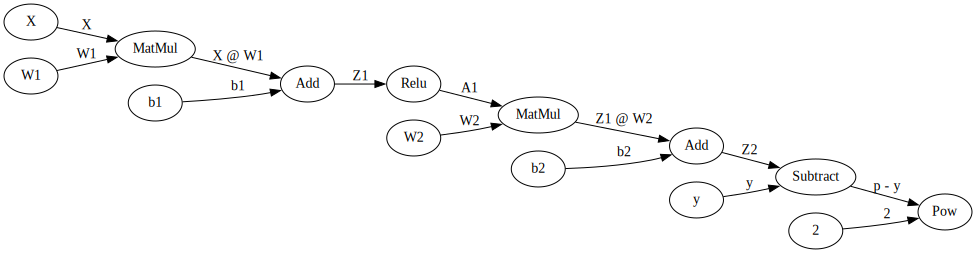

In [7]:
pow.generate_graph()

In [8]:
pow.zero_grad()
pow.apply_bwd(1)

np.allclose(l1_w_grad, w1_param.grad)

True

In [9]:
w1_param.grad

array([[2.59973960e+04, 2.29391714e+04, 8.81656124e+03],
       [2.00402621e+04, 1.76828097e+04, 6.79630366e+03],
       [3.62551403e+01, 3.19902376e+01, 1.22952954e+01]])

In [10]:
l1_w_grad

array([[2.59973960e+04, 2.29391714e+04, 8.81656124e+03],
       [2.00402621e+04, 1.76828097e+04, 6.79630366e+03],
       [3.62551403e+01, 3.19902376e+01, 1.22952954e+01]])

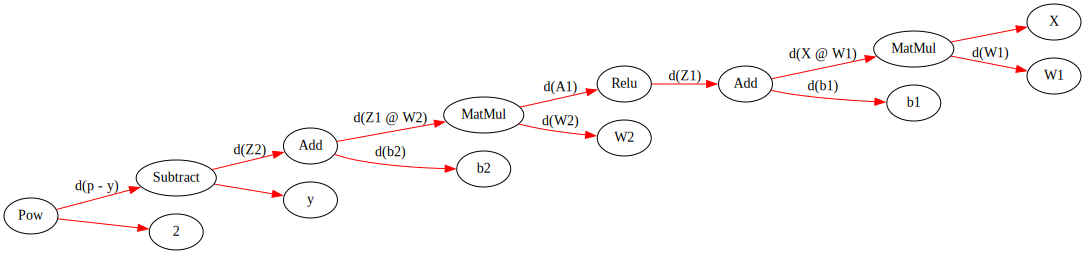

In [11]:
pow.generate_graph(backward=True)

In [12]:
pow.zero_grad()
pow.generate_derivative_chains()
display_chain(w1_param.display_partial_derivative())

<IPython.core.display.Latex object>

In [13]:
class Exp(Node):
    def forward(self, x):
        return np.exp(x)

    def backward(self, grad):
        x = self.cache[0]
        return np.exp(x) * grad

class Max(Node):
    def forward(self, x):
        return np.max(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0]
        new_grad = np.array(grad)
        max = np.max(x, axis=-1).reshape(-1,1)
        new_grad[x < max] = 0
        return new_grad

class Sum(Node):
    def forward(self, x):
        return np.sum(x, axis=-1).reshape(-1,1)

    def backward(self, grad):
        x = self.cache[0]
        return np.ones_like(x) * grad

class Multiply(Node):
    def forward(self, x, y):
        return x * y

    def backward(self, grad):
        x, y = self.cache
        return grad * y, grad * x

In [14]:
x = np.random.rand(10, 3)
y = np.zeros_like(x)
inds = (np.arange(0,y.shape[0]), np.random.randint(0, 3, size=y.shape[0]))
y[inds] = 1

In [15]:
def calculate_staged_softmax_grad(x, y):
    max = np.max(x, axis=-1).reshape(-1,1)
    subtracted = x - max
    raised = np.exp(subtracted)
    summed = np.sum(raised, axis=-1).reshape(-1,1)
    inverted = 1 / summed
    softmax = raised * inverted

    loss_grad = -1 * y / softmax # (10,3)

    raised_grad = loss_grad * inverted # (10,3)
    inverted_grad = loss_grad * raised # (10,3)
    inverted_grad = np.sum(inverted_grad, axis=-1).reshape(-1,1) # (10,1)
    summed_grad = (-1 * summed ** -2) * inverted_grad # (10,1)
    summed_grad = np.ones_like(raised) * summed_grad # (10,3)
    raised_grad_2 = summed_grad # (10,3)
    raised_grad += raised_grad_2 # (10,3)
    x_grad = raised_grad * np.exp(subtracted)# (10,3)

    return softmax, x_grad

staged_softmax, staged_softmax_grad = calculate_staged_softmax_grad(x, y)

In [16]:
normalized_x = x - np.max(x, axis=-1).reshape(-1,1)
X = Parameter(normalized_x, desc="X", needs_grad=True)

raised = Exp(X, out="e^X")
summed = Sum(raised, out="sum(e^X)")

negative_one = Parameter(-1, desc="-1", needs_grad=False)
inverted = Pow(summed, negative_one, out="1 / sum(e^X)")
softmax = Multiply(raised, inverted, out="softmax(X)")

operations_softmax = softmax.apply_fwd()
operations_softmax

array([[0.26267259, 0.48898284, 0.24834456],
       [0.27928613, 0.39381418, 0.32689969],
       [0.28961174, 0.25444979, 0.45593848],
       [0.29896886, 0.3395233 , 0.36150784],
       [0.46964824, 0.29447068, 0.23588108],
       [0.23075283, 0.42898035, 0.34026682],
       [0.48314569, 0.29229168, 0.22456263],
       [0.4414144 , 0.29480312, 0.26378247],
       [0.23080538, 0.23338722, 0.53580741],
       [0.35380791, 0.25855315, 0.38763895]])

In [17]:
np.allclose(staged_softmax, operations_softmax)

True

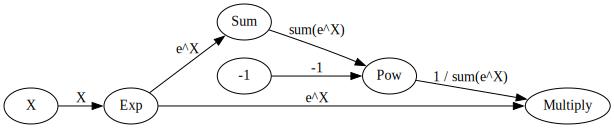

In [18]:
softmax.generate_graph()

In [19]:
loss_grad = -1 * y / operations_softmax

softmax.zero_grad()
softmax.apply_bwd(loss_grad)
operations_softmax_grad = X.grad

operations_softmax_grad

array([[ 0.26267259,  0.48898284, -0.75165544],
       [ 0.27928613,  0.39381418, -0.67310031],
       [-0.71038826,  0.25444979,  0.45593848],
       [ 0.29896886, -0.6604767 ,  0.36150784],
       [-0.53035176,  0.29447068,  0.23588108],
       [-0.76924717,  0.42898035,  0.34026682],
       [ 0.48314569, -0.70770832,  0.22456263],
       [ 0.4414144 , -0.70519688,  0.26378247],
       [ 0.23080538, -0.76661278,  0.53580741],
       [-0.64619209,  0.25855315,  0.38763895]])

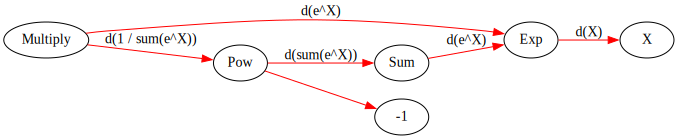

In [20]:
softmax.generate_graph(backward=True)

In [21]:
softmax.zero_grad()
softmax.generate_derivative_chains()
display_chain(X.display_partial_derivative())

<IPython.core.display.Latex object>

In [22]:
def calculate_derived_softmax_row(Sz):
    N = Sz.shape[0]
    D = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            D[i, j] = Sz[i, 0] * (np.float32(i == j) - Sz[j, 0])
    return D

def calculate_derived_softmax_grad(softmaxes, loss_grad):
    output = np.zeros_like(softmaxes)
    for i in range(softmaxes.shape[0]):
        row_grad = calculate_derived_softmax_row(softmaxes[i,:].reshape(-1,1)) * loss_grad[i,:].reshape(1,-1)
        output[i,:] = np.sum(row_grad, -1)
    return output

def calculate_derived_softmax(z):
    nz = z - np.max(z, axis=-1).reshape(-1,1)
    sm = np.exp(nz) / np.sum(np.exp(nz), axis=-1).reshape(-1,1)
    return sm

derived_softmax = calculate_derived_softmax(x)
np.allclose(derived_softmax, operations_softmax)

True

In [23]:
loss_grad = -1 * y / derived_softmax
derived_softmax_grad = calculate_derived_softmax_grad(derived_softmax, loss_grad)

np.allclose(derived_softmax_grad, derived_softmax - y)

True

In [25]:
np.allclose(derived_softmax_grad, operations_softmax_grad)

True